In [14]:
import numpy as np
import hddCRP.markovModeling as mm
import hddCRP.dataLoader as dl
import matplotlib.pyplot as plt

In [15]:
# make sequence to fit (totally random)
K = 3
rng = np.random.Generator(np.random.MT19937(1023))
seq = rng.integers(0,K,size=(100))
symbols = range(K)
seq


array([0, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2,
       2, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2, 1,
       0, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0,
       2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 2,
       2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 2])

In [16]:
depth = 2 # how far back in time to care about dependencies (1=only look at previous action)

C = mm.get_transition_count(seq, depth=depth, symbols=symbols)
P = mm.get_transition_probabilities(C) # the plugin estimator for the transitions

# I also have some Bayesian estimation options
P1 = mm.get_transition_probabilities(C, alpha=1, rng=None) # add a regularization term in a simple categorical-dirichlet model for posterior mean estimates
P2 = mm.get_transition_probabilities(C, alpha=1, rng=rng) # can also draw P from the posterior over P under the categorical-dirichlet model
                                                          # This can help us figure out if the uncertainty in our estimates matters
P3 = mm.get_transition_probabilities_hierarchical(C, alpha=1, rng=None) #changes up the regularization using a very quick hierarchical scheme
P4 = mm.get_transition_probabilities_hierarchical(C, alpha=1, rng=rng) # 

P[1,1,:]

array([0.27272727, 0.27272727, 0.45454545])

In [17]:
initial_state = [0,1] # I ended up requiring an initial state to start the simulation - otherwise I wouldn't be sure how you'd want to begin
simulated_seqs = mm.simulate_from_model(P, initial_state, sim_length=100, rng=rng, nsims=10)
simulated_seqs # each column is one simulation (first steps are set to initial_state)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 2, 0, 1, 2, 1, 2, 2, 1, 1],
       [2, 2, 2, 0, 2, 2, 1, 2, 0, 2],
       [1, 1, 1, 1, 2, 1, 1, 2, 1, 2],
       [1, 2, 0, 2, 2, 2, 0, 2, 0, 0],
       [1, 0, 2, 0, 2, 0, 2, 0, 1, 1],
       [2, 1, 2, 0, 2, 1, 1, 1, 2, 2],
       [2, 1, 2, 0, 2, 1, 1, 0, 2, 2],
       [2, 0, 2, 1, 2, 1, 2, 2, 1, 1],
       [2, 2, 0, 2, 2, 2, 0, 1, 2, 1],
       [2, 1, 0, 2, 0, 0, 2, 0, 0, 2],
       [0, 1, 0, 0, 0, 1, 2, 1, 2, 0],
       [1, 0, 1, 0, 1, 0, 2, 0, 0, 2],
       [0, 2, 1, 0, 1, 1, 2, 2, 1, 1],
       [2, 0, 0, 2, 2, 1, 2, 0, 1, 1],
       [0, 1, 1, 2, 0, 0, 2, 0, 2, 0],
       [1, 1, 2, 2, 1, 2, 0, 1, 1, 1],
       [0, 0, 0, 2, 2, 0, 1, 1, 0, 0],
       [2, 1, 0, 1, 2, 2, 2, 2, 1, 2],
       [0, 1, 1, 0, 0, 0, 0, 2, 1, 0],
       [2, 2, 2, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 2, 1, 0, 1, 1, 0, 2, 2],
       [0, 1, 0, 2, 2, 0, 1, 2, 0, 2],
       [0, 2, 1, 0, 1, 1, 1, 1, 1, 0],
       [1, 0, 2, 2, 1, 0,

In [18]:
# with multiple sessions, there's a boundary problem at the start of each session.
# Conditional counts can still be extracted by summation over each session
seqs = [];
for ii in range(2):
    seqs += [rng.integers(0,K,size=(100))]

C = 0
for ss in seqs:
    C = C + mm.get_transition_count(ss, depth=depth, symbols=symbols)
P = mm.get_transition_probabilities(C) # the plugin estimator for the transitions

In [19]:
transition_matrices = {}
N_sessions = 2;
symbols = [0,1,2]
depth = 2;
alpha_hierarchical = [1,8,32];
alpha = 1;

for grp in dl.grp_names:
    C_a = 0
    C_b = 0
    for sub in dl.get_subjects(grp):
        seqs = dl.get_phase1_a(sub)[-N_sessions:]
        for ss in seqs:
            C_a = C_a + mm.get_transition_count(ss, depth=depth, symbols=symbols)
        seqs = dl.get_phase1_b(sub)[-N_sessions:]
        for ss in seqs:
            C_b = C_b + mm.get_transition_count(ss, depth=depth, symbols=symbols)
    # P_a = mm.get_transition_probabilities_hierarchical(C_a, alpha = alpha_hierarchical);
    # P_b = mm.get_transition_probabilities_hierarchical(C_b, alpha = alpha_hierarchical);
    P_a = mm.get_transition_probabilities(C_a, alpha = alpha);
    P_b = mm.get_transition_probabilities(C_b, alpha = alpha);
    transition_matrices[grp] = (P_a, P_b)

In [20]:
mixing_coefs = np.linspace(0,1,20)
pred_lls = {}

for grp in dl.grp_names_all:
    ll = np.zeros((len(dl.get_subjects(grp)), mixing_coefs.size, len(dl.grp_names)))
    for ii, sub in enumerate(dl.get_subjects(grp)):
        seq = dl.get_phase2(sub)[0][:20+depth]

        for jj, train_grp in enumerate(dl.grp_names):
            for kk, aa in enumerate(mixing_coefs): 
                P = aa*transition_matrices[train_grp][0] + (1-aa)*transition_matrices[train_grp][1] 
                ll[ii, kk, jj] = mm.get_sequence_likelihood(seq, P)

    pred_lls[grp] = ll

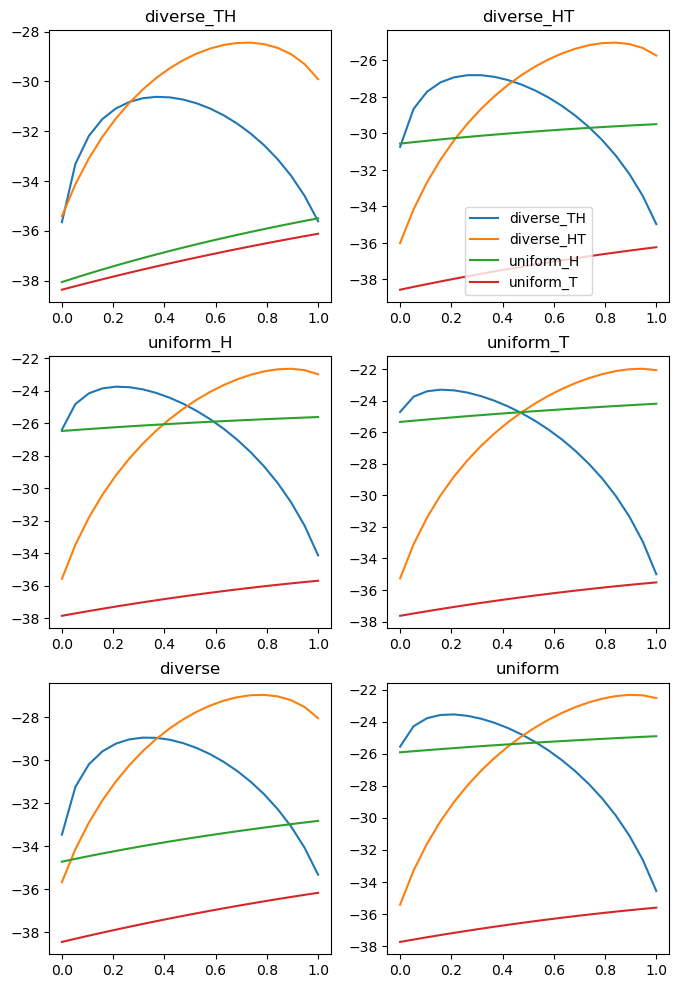

In [21]:
plt.figure(figsize=(8,12))
for ii, grp in enumerate(dl.grp_names_all):
    plt.subplot(len(dl.grp_names_all)//2 + len(dl.grp_names_all)%2,2,ii+1)
    plt.plot(mixing_coefs, pred_lls[grp].mean(axis=0))
    plt.title(grp)
    if(ii == 1):
       plt.legend(dl.grp_names)